# Image Generation with IP-Adapter (SD 1.5)

This notebook demonstrates how to use the DEGIS package to:
1. Load trained color head models
2. Set up IP-Adapter with ControlNet for image generation
3. Generate images using color and layout control

Based on the ablation notebook but using the new package structure.


## 1. Setup and Install Dependencies


In [1]:
# # Install IP-Adapter and dependencies
# %pip uninstall -y ip-adapter diffusers
# %pip install --no-cache-dir git+https://github.com/Ahmed-Sherif-ASA/IP-Adapter@main
# %pip install diffusers


## 2. Imports and Setup


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torchvision import transforms
from IPython.display import display
import os
import glob

# Import the DEGIS package
import degis
from degis.data.dataset import UnifiedImageDataset
from degis.config import CSV_PATH, EMBEDDINGS_TARGET_PATH, COLOR_HIST_PATH_HCL_514, EDGE_MAPS_PATH

# Import IP-Adapter
import ip_adapter
from ip_adapter import IPAdapter
from diffusers import ControlNetModel, StableDiffusionControlNetPipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model projection_dim: 1280
Using device: cuda


## 3. Load Data and Models


In [3]:
embeddings_path = EMBEDDINGS_TARGET_PATH # || YOUR_CUSTOM_PATH
colour_path = COLOR_HIST_PATH_HCL_514 # options: COLOR_HIST_PATH_LAB_514 || COLOR_HIST_PATH_RGB || YOUR_CUSTOM_PATH
edge_maps_path = EDGE_MAPS_PATH # || YOUR_CUSTOM_PATH
colour_head_checkpoint_path = "/data/degis/runs/hcl514_tk100_b4096-20250827-222013/best_color_head_tmp_hcl.pth" # || YOUR_CUSTOM_PATH
ip_ckpt = "/data/thesis/models/ip-adapter_sd15.bin"
image_encoder_path = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
controlnet_id = "lllyasviel/control_v11p_sd15_canny"
stable_diffusion_model_id = "runwayml/stable-diffusion-v1-5"

In [4]:
# Load datasets
df = pd.read_csv(CSV_PATH)
colour_dataset = UnifiedImageDataset(
    df.rename(columns={"local_path": "file_path"}),
    mode="file_df",
    size=(224, 224),
    subset_ratio=1.0
)

# Load precomputed data
embeddings = np.load(embeddings_path, mmap_mode="r").astype(np.float32, copy=False)
histograms = np.load(colour_path, mmap_mode="r").astype(np.float32, copy=False)
edge_maps = np.load(edge_maps_path, mmap_mode="r")

print(f"Loaded embeddings: {embeddings.shape}")
print(f"Loaded histograms: {histograms.shape}")
print(f"Loaded edge maps: {edge_maps.shape}")

# Load trained color head
color_head = degis.load_trained_color_head(
    checkpoint_path=colour_head_checkpoint_path,
    clip_dim=embeddings.shape[1],
    hist_dim=histograms.shape[1],
    device=device
)
print("✓ Color head loaded successfully")


Loaded embeddings: (3336240, 1024)
Loaded histograms: (3336240, 514)
Loaded edge maps: (3336240, 50176)
✓ Color head loaded successfully


## 4. Setup IP-Adapter Pipeline


In [5]:
# Setup cache directory
HF_CACHE = "/data/hf-cache" if os.path.exists("/data") else "./hf-cache"
os.makedirs(HF_CACHE, exist_ok=True)

os.environ["HF_HOME"] = HF_CACHE
os.environ["HUGGINGFACE_HUB_CACHE"] = os.path.join(HF_CACHE, "hub")
os.environ["TRANSFORMERS_CACHE"] = os.path.join(HF_CACHE, "transformers")
os.environ["DIFFUSERS_CACHE"] = os.path.join(HF_CACHE, "diffusers")
os.environ["TORCH_HOME"] = os.path.join(HF_CACHE, "torch")

print(f"Using cache directory: {HF_CACHE}")

# Create IP-Adapter generator
generator = degis.IPAdapterGenerator(device=device)

# Setup the pipeline
generator.setup_pipeline(
    model_id=stable_diffusion_model_id,
    controlnet_id=controlnet_id,
    ip_ckpt=ip_ckpt,
    image_encoder_path=image_encoder_path,
    cache_dir=HF_CACHE,
    torch_dtype=torch.float16,
)

print("✓ IP-Adapter pipeline setup complete")


Using cache directory: /data/hf-cache


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


✓ IP-Adapter pipeline setup complete


## 5. Image Generation Functions


In [6]:
def generate_from_dataset_id(
    colour_index: int,
    layout_index: int,
    prompt: str = "a cat playing with a ball",
    guidance_scale: float = 7.5,
    steps: int = 30,
    controlnet_conditioning_scale: float = 1.0,
    num_samples: int = 1,
    scale: float = 0.8,
):
    """Generate images using color and layout control."""
    
    # Get original image for display
    img_t, _ = colour_dataset[colour_index]
    pil_img = transforms.ToPILImage()(img_t)
    
    # Get CLIP embedding and compute color embedding
    z_clip = torch.as_tensor(embeddings[colour_index], dtype=torch.float32, device=device).unsqueeze(0)
    color_embedding = degis.get_color_embedding(color_head, z_clip)
    
    # Create control image from edge data
    control_image = degis.create_edge_control_image(edge_maps[layout_index], size=512)
    
    # Generate images
    images = generator.generate(
        color_embedding=color_embedding,
        control_image=control_image,
        prompt=prompt,
        negative_prompt=(
            "monochrome, lowres, bad anatomy, worst quality, low quality, blurry, "
            "sketch, cartoon, drawing, anime:1.4, comic, illustration, posterized, "
            "mosaic, stained glass, abstract, surreal, psychedelic, trippy, texture artifact, "
            "embroidery, knitted, painting, oversaturated, unrealistic, bad shading"
        ),
        num_samples=num_samples,
        guidance_scale=guidance_scale,
        num_inference_steps=steps,
        controlnet_conditioning_scale=controlnet_conditioning_scale,
        scale=scale,
    )
    
    # Display results
    comparison = degis.display_comparison_grid(
        original=pil_img,
        control=control_image,
        generated=images,
        cols=3
    )
    display(comparison)
    
    return images

print("✓ Generation function defined")


✓ Generation function defined


## 6. Generate Images


Generating images with IP-Adapter (SD 1.5)...


/tmp/ipykernel_724847/429353600.py:18: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  z_clip = torch.as_tensor(embeddings[colour_index], dtype=torch.float32, device=device).unsqueeze(0)


  0%|          | 0/30 [00:00<?, ?it/s]

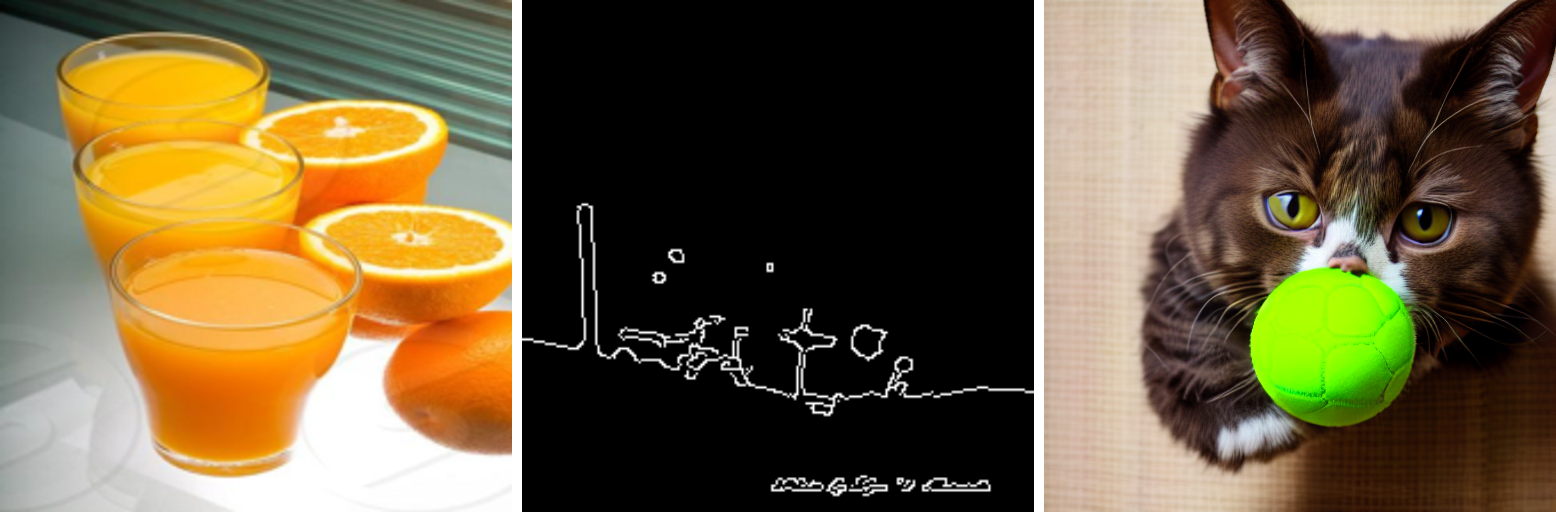

  0%|          | 0/30 [00:00<?, ?it/s]

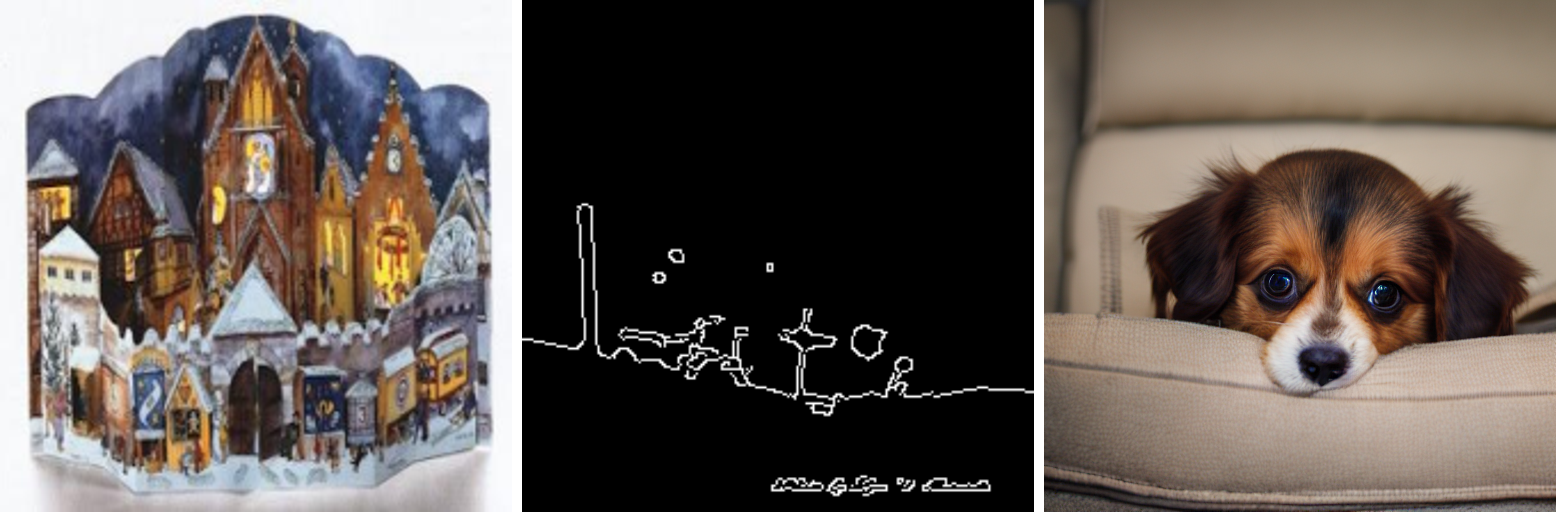

  0%|          | 0/50 [00:00<?, ?it/s]

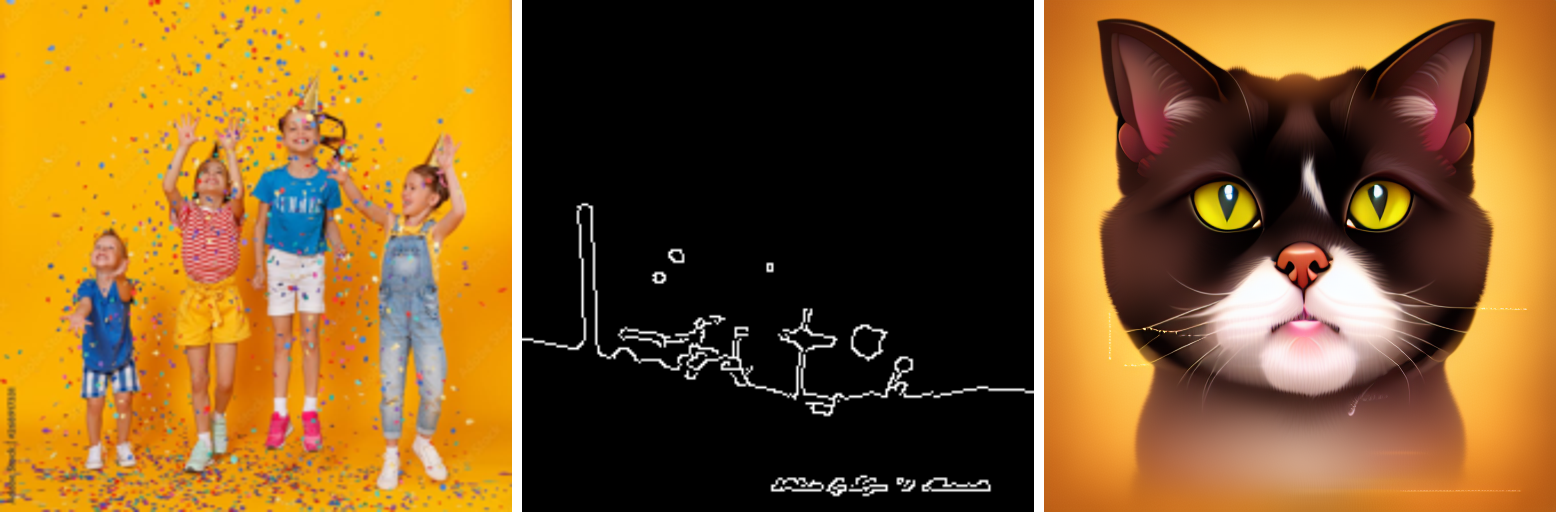

✓ Image generation complete!


In [ ]:
# Generate images with different prompts and parameters
print("Generating images with IP-Adapter (SD 1.5)...")

# Example 1: Cat with ball
images1 = generate_from_dataset_id(
    colour_index=1000,
    layout_index=33,
    prompt="a cat playing with a ball",
    guidance_scale=7.5,
    steps=30,
    controlnet_conditioning_scale=1.0,
    num_samples=1,
    scale=0.8,
)

# Example 2: Dog on hoodie
images2 = generate_from_dataset_id(
    colour_index=1008,
    layout_index=33,
    prompt="a dog on the hoodie",
    guidance_scale=7.5,
    steps=30,
    controlnet_conditioning_scale=1.0,
    num_samples=1,
    scale=0.8,
)

# Example 3: Different style
images3 = generate_from_dataset_id(
    colour_index=1003,
    
    layout_index=33,
    prompt="A cat on the hoodie, digital art style",
    guidance_scale=13.0,
    steps=50,
    controlnet_conditioning_scale=0.8,
    num_samples=1,
    scale=0.6,
)

print("✓ Image generation complete!")
